# Experiments

#### Imports:

In [15]:
import os
import sys
import math
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

#### Constants:

In [16]:
CSV_PATH = "complete-frame.csv"

#### Aux functions:

In [17]:
def silent_evaluation(model, x_test, y_test):
    f = open('/dev/null', 'w')
    regular_stdout = sys.stdout
    sys.stdout = f
    test_loss, test_acc = model.evaluate(x_test, y_test)
    sys.stdout = regular_stdout
    print('Model Accuracy: {}'.format(test_acc))
    
    
def split_data(train_x, train_y, training=0.70, validation=0.5):
    train_size = training

    train_cnt = math.floor(train_x.shape[0] * train_size)
    x_train = train_x.iloc[0:train_cnt].values
    y_train = train_y.iloc[0:train_cnt].values
    x_test = train_x.iloc[train_cnt:]
    y_test = train_y.iloc[train_cnt:]

    division = validation

    train_cnt = math.floor(x_test.shape[0] * division)
    x_validate = x_test.iloc[0:train_cnt].values
    y_validate = y_test.iloc[0:train_cnt].values
    x_test = x_test.iloc[train_cnt:].values
    y_test = y_test.iloc[train_cnt:].values

    return x_train, y_train, x_test, y_test, x_validate, y_validate


def plot_graphs(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

#### Load data:

In [18]:
def load_frame():
    frame = pd.read_csv(CSV_PATH, sep=",")
    frame = frame.sample(frac=1).reset_index(drop=True)
    return frame

def load_quartile(frame):
    low, high = frame.mutation.quantile([0.25,0.75])
    frame_low = frame.query('mutation<{low}'.format(low=low))
    frame_high = frame.query('mutation>{high}'.format(high=high))
    frame_low['mutation'] = 0
    frame_high['mutation'] = 1
    frame = pd.concat([frame_low, frame_high], ignore_index=True)
    frame = frame.sample(frac=1).reset_index(drop=True)
    return frame;

def load_meaningful_subset(frame):
    columns = [frame.no_mutations,
                         #frame.line_coverage,
                         frame.csm_FE,
                         frame.CONNECTIVITY_prod,
                         frame.CONNECTIVITY_test,
                         frame.isEagerTest,
                         frame.LOC_prod, frame.LOC_test, frame.WMC_prod,
                         frame.LCOM1_prod, frame.LCOM2_prod,
                         frame.LCOM4_prod, frame.McCABE_prod,
                         frame.RFC_prod, frame.MPC_prod,
                         frame.RFC_test, frame.MPC_test,
                         frame.LCOM1_test, frame.LCOM2_test,
                         frame.LCOM4_test, frame.LCC_test,
                         frame.LCC_test, frame.WMC_test,
                         frame.McCABE_test, frame.NOP_prod]
    
    data_x = pd.concat(columns, axis = 1).round(2)
    data_y = pd.concat([frame.mutation], axis = 1)
    return data_x, data_y, len(columns)


def load_all_data(frame):
    columns = [frame.no_mutations, frame.line_coverage, frame.isAssertionRoulette, frame.isEagerTest, frame.isLazyTest,
frame.isMysteryGuest, frame.isSensitiveEquality, frame.isResourceOptimism, frame.isForTestersOnly,
frame.isIndirectTesting, frame.LOC_prod, frame.HALSTEAD_prod, frame.RFC_prod, frame.CBO_prod, frame.MPC_prod, frame.IFC_prod, frame.DAC_prod,frame.DAC2_prod, frame.LCOM1_prod, frame.LCOM2_prod,
frame.LCOM3_prod, frame.LCOM4_prod, frame.CONNECTIVITY_prod, frame.LCOM5_prod, frame.COH_prod, frame.TCC_prod,
frame.LCC_prod, frame.ICH_prod, frame.WMC_prod, frame.NOA_prod, frame.NOPA_prod, frame.NOP_prod,
frame.McCABE_prod, frame.BUSWEIMER_prod, frame.LOC_test, frame.HALSTEAD_test, frame.RFC_test, frame.CBO_test,
frame.MPC_test, frame.IFC_test, frame.DAC_test, frame.DAC2_test, frame.LCOM1_test, frame.LCOM2_test,
frame.LCOM3_test, frame.LCOM4_test, frame.CONNECTIVITY_test, frame.LCOM5_test, frame.COH_test, frame.TCC_test,
frame.LCC_test, frame.ICH_test, frame.WMC_test, frame.NOA_test, frame.NOPA_test, frame.NOP_test, frame.McCABE_test,
frame.BUSWEIMER_test, frame.csm_CDSBP, frame.csm_CC, frame.csm_FD, frame.csm_Blob, frame.csm_SC, frame.csm_MC,
frame.csm_LM, frame.csm_FE, frame.prod_readability, frame.test_readability]
    
    data_x = pd.concat(columns, axis = 1).round(2)
    data_y = pd.concat([frame.mutation], axis = 1)
    return data_x, data_y, len(columns)

#### Data Manipulations:

In [19]:
def median(data_x, data_y, frame):
    labels = [1,2]
    bins = [0,frame.mutation.median(),1]
    frame['mutation_bins'] = pd.cut(frame.mutation, bins=bins, labels = labels, include_lowest=True)
    data_y = pd.concat([frame.mutation_bins], axis = 1)
    return split_data(data_x, data_y)

## Experiment #1: Effective Vs. Non Effective
    - 2 classes: effective tests and non-effective tests:
        - Effective > median(mutation_score)
        - Non Effective < media(mutation_score)

Model Accuracy: 0.7396694421768188


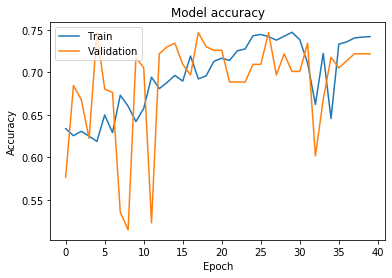

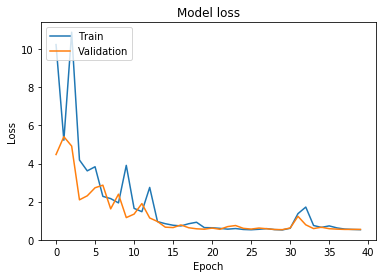

Overfit checks:
Model Accuracy: 0.7510373592376709


In [6]:
frame = load_frame()
data_x, data_y, number_of_features = load_meaningful_subset(frame)
x_train, y_train, x_test, y_test, x_validate, y_validate = median(data_x, data_y, frame)

model = keras.Sequential()
#model.add(keras.layers.Dense(number_of_features, input_dim=number_of_features, activation=tf.nn.relu))
#model.add(keras.layers.Dense(15, activation=tf.nn.relu))
#model.add(keras.layers.Dense(8, activation=tf.nn.relu))
#model.add(keras.layers.Dense(3, activation=tf.nn.softmax))

model.add(keras.layers.Dense(500, activation='relu', input_dim=number_of_features))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping_monitor = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=1000, verbose=0,
          validation_data=(x_validate, y_validate), callbacks=[early_stopping_monitor])

silent_evaluation(model, x_test, y_test)
plot_graphs(history)
print("Overfit checks:")
silent_evaluation(model, x_train, y_train)

## Experiment #2: Predicting Mutation Score
    - 11 categories of mutation score: from 0, 0.1, 0.2, .... 1
    - The goal: predict the mutation score

Model Accuracy: 0.24793387949466705


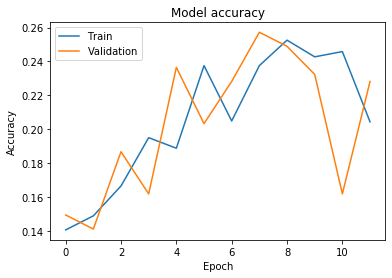

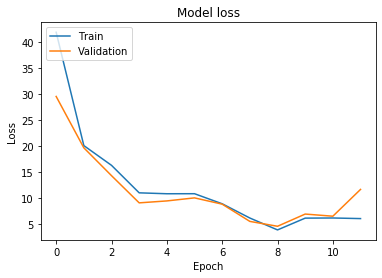

Overfit checks:
Model Accuracy: 0.2562240660190582


In [7]:
frame = load_frame()
data_x, data_y, number_of_features = load_meaningful_subset(frame)
data_y = pd.concat([frame.mutation], axis = 1).round(1).mul(10)
x_train, y_train, x_test, y_test, x_validate, y_validate = split_data(data_x, data_y)

model = keras.Sequential()
model.add(keras.layers.Dense(500, activation='relu', input_dim=number_of_features))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(11, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping_monitor = keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=1000, verbose=0,
          validation_data=(x_validate, y_validate), callbacks=[early_stopping_monitor])

silent_evaluation(model, x_test, y_test)
plot_graphs(history)
print("Overfit checks:")
silent_evaluation(model, x_train, y_train)

## Experiment #3: All data
    - 2 categories
    - The goal: predict the mutation score

In [8]:
frame = load_frame()
data_x, data_y, number_of_features = load_all_data(frame)
x_train, y_train, x_test, y_test, x_validate, y_validate = median(data_x, data_y, frame)


model = keras.Sequential()
model.add(keras.layers.Dense(number_of_features, input_dim=number_of_features, activation=tf.nn.relu))
model.add(keras.layers.Dense(15, activation=tf.nn.relu))
model.add(keras.layers.Dense(8, activation=tf.nn.relu))
model.add(keras.layers.Dense(3, activation=tf.nn.softmax))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping_monitor = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=1000, verbose=1)#,
          #validation_data=(x_validate, y_validate), callbacks=[early_stopping_monitor])

silent_evaluation(model, x_test, y_test)
plot_graphs(history)
print("Overfit checks:")
silent_evaluation(model, x_train, y_train)

Train on 1928 samples
Epoch 1/1000
1928/1928 [==============================] - 1s 454us/sample - loss: nan - accuracy: 0.0270
Epoch 2/1000
1928/1928 [==============================] - 0s 95us/sample - loss: nan - accuracy: 0.0000e+00
Epoch 3/1000
1928/1928 [==============================] - 0s 90us/sample - loss: nan - accuracy: 0.0000e+00
Epoch 4/1000
1928/1928 [==============================] - 0s 99us/sample - loss: nan - accuracy: 0.0000e+00
Epoch 5/1000
1928/1928 [==============================] - 0s 103us/sample - loss: nan - accuracy: 0.0000e+00
Epoch 6/1000
1928/1928 [==============================] - 0s 106us/sample - loss: nan - accuracy: 0.0000e+00
Epoch 7/1000
1928/1928 [==============================] - 0s 94us/sample - loss: nan - accuracy: 0.0000e+00
Epoch 8/1000
1928/1928 [==============================] - 0s 99us/sample - loss: nan - accuracy: 0.0000e+00
Epoch 9/1000
1928/1928 [==============================] - 0s 94us/sample - loss: nan - accuracy: 0.0000e+00
Epoch 1

KeyboardInterrupt: 

## Experiment 4: 1st and 4th quartile
    - 2 categories
    - The goal: predict the mutation score

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


(843, 68)
---------------- Round #0 ----------------
Model Accuracy: 0.8397790193557739


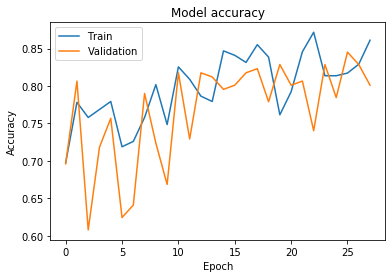

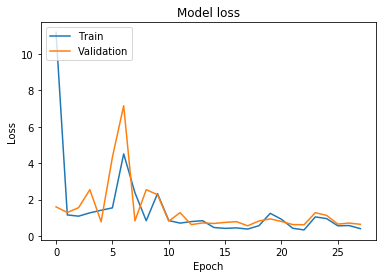

Overfit checks:
Model Accuracy: 0.86358243227005
---------------- Round #1 ----------------
Model Accuracy: 0.889502763748169


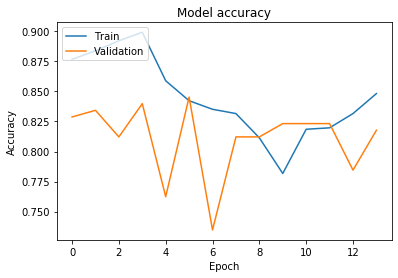

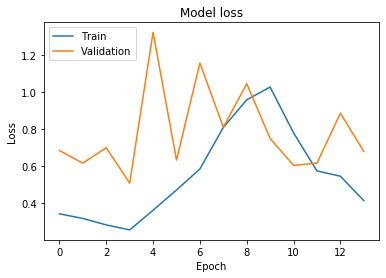

Overfit checks:
Model Accuracy: 0.9062870740890503
---------------- Round #2 ----------------


KeyboardInterrupt: 

In [26]:
frame = load_frame()
frame = load_quartile(frame)
data_x, data_y, number_of_features = load_all_data(frame) #load_meaningful_subset(frame)
x_train, y_train, x_test, y_test, x_validate, y_validate = split_data(data_x, data_y) #median(data_x, data_y, frame)

print(x_train.shape)
model = keras.Sequential()
model.add(keras.layers.Dense(500, activation='relu', input_dim=number_of_features))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(2, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping_monitor = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

for i in range(0,10):
    print("---------------- Round #{} ----------------".format(i))

    history = model.fit(x_train, y_train, epochs=1000, verbose=0,
              validation_data=(x_validate, y_validate), callbacks=[early_stopping_monitor])
    silent_evaluation(model, x_test, y_test)
    plot_graphs(history)
    print("Overfit checks:")
    silent_evaluation(model, x_train, y_train)

## Misc.